<a href="https://colab.research.google.com/github/naufalsadid/image/blob/main/Enkripsi_Photo_DES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

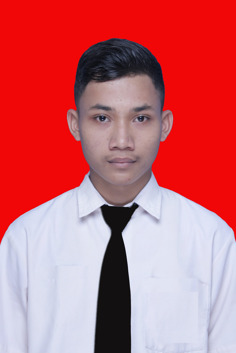

CAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfxCAfx

In [1]:
import struct
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from google.colab.patches import cv2_imshow
import warnings
from io import BytesIO
import base64

warnings.simplefilter("ignore", DeprecationWarning)

try:
    number_type = int, long
except NameError:
    number_type = int

try:
    iter_range = xrange
except NameError:
    iter_range = range

class DesKey(object):
    def __init__(self, key):
        self.__encryption_key = guard_key(key)
        self.__decryption_key = self.__encryption_key[::-1]
        self.__key = key

    def encrypt(self, message, initial=None, padding=False):
        return handle(message, self.__encryption_key, initial, padding, 1)

    def decrypt(self, message, initial=None, padding=False):
        return handle(message, self.__decryption_key, initial, padding, 0)

    def is_single(self):
        return len(self.__encryption_key) == 1

    def is_triple(self):
        return len(self.__encryption_key) == 3

    def __hash__(self):
        return hash((self.__class__, self.__encryption_key))


def encode(block, key, encryption):
    for k in key:
        block = encode_block(block, k, encryption)
        encryption = not encryption

    return block


def guard_key(key):
    if isinstance(key, bytearray):
        key = bytes(key)

    assert isinstance(key, bytes), "Kunci harus dalam bytes atau bytesarray"
    assert len(key) in (8, 16, 24), "Kunci harus sepanjang 8, 16, or 24"

    k0, k1, k2 = key[:8], key[8:16], key[16:]
    if k1 == k2:
        return tuple(derive_keys(k0)),

    k2 = k2 or k0
    if k1 == k0:
        return tuple(derive_keys(k2)),

    return tuple(tuple(derive_keys(k)) for k in (k0, k1, k2))

def guard_message(message, padding, encryption):
    assert isinstance(message, bytes), "Plaintext harus dalam bytes"
    length = len(message)
    if encryption and padding:
        return message.ljust(length + 8 >> 3 << 3, bytes((8 - (length & 7), )))

    assert length & 7 == 0, (
    )
    return message

def guard_initial(initial):
    if initial is not None:
        if isinstance(initial, bytearray):
            initial = bytes(initial)
        if isinstance(initial, bytes):
            assert len(initial) & 7 == 0, "Nilai initial harus sepanjang 8 bytes"
            return struct.unpack(">Q", initial)[0]
        assert isinstance(initial, number_type), "Nilai initial harus integer atau bytes"
        assert -1 < initial < 1 << 32, "Nilai initial harus dalam jangkauan [0, 2**32) (jika dalam integer)"
    return initial

def handle(message, key, initial, padding, encryption):
    message = guard_message(message, padding, encryption)
    initial = guard_initial(initial)

    blocks = (struct.unpack(">Q", message[i: i + 8])[0] for i in iter_range(0, len(message), 8))

    if initial is None:
        # ECB
        encoded_blocks = ecb(blocks, key, encryption)
    else:
        # CBC
        encoded_blocks = cbc(blocks, key, initial, encryption)

    ret = b"".join(struct.pack(">Q", block) for block in encoded_blocks)
    return ret[:-ord(ret[-1:])] if not encryption and padding else ret


def ecb(blocks, key, encryption):
    for block in blocks:
        yield encode(block, key, encryption)


def cbc(blocks, key, initial, encryption):
    if encryption:
        for block in blocks:
            initial = encode(block ^ initial, key, encryption)
            yield initial
    else:
        for block in blocks:
            initial, block = block, initial ^ encode(block, key, encryption)
            yield block

INITIAL_PERMUTATION = (
    57, 49, 41, 33, 25, 17, 9,  1,
    59, 51, 43, 35, 27, 19, 11, 3,
    61, 53, 45, 37, 29, 21, 13, 5,
    63, 55, 47, 39, 31, 23, 15, 7,
    56, 48, 40, 32, 24, 16, 8,  0,
    58, 50, 42, 34, 26, 18, 10, 2,
    60, 52, 44, 36, 28, 20, 12, 4,
    62, 54, 46, 38, 30, 22, 14, 6,
)

INVERSE_PERMUTATION = (
    39, 7,  47, 15, 55, 23, 63, 31,
    38, 6,  46, 14, 54, 22, 62, 30,
    37, 5,  45, 13, 53, 21, 61, 29,
    36, 4,  44, 12, 52, 20, 60, 28,
    35, 3,  43, 11, 51, 19, 59, 27,
    34, 2,  42, 10, 50, 18, 58, 26,
    33, 1,  41, 9,  49, 17, 57, 25,
    32, 0,  40, 8,  48, 16, 56, 24,
)

EXPANSION = (
    31, 0,  1,  2,  3,  4,
    3,  4,  5,  6,  7,  8,
    7,  8,  9,  10, 11, 12,
    11, 12, 13, 14, 15, 16,
    15, 16, 17, 18, 19, 20,
    19, 20, 21, 22, 23, 24,
    23, 24, 25, 26, 27, 28,
    27, 28, 29, 30, 31, 0,
)

PERMUTATION = (
    15, 6,  19, 20, 28, 11, 27, 16,
    0,  14, 22, 25, 4,  17, 30, 9,
    1,  7,  23, 13, 31, 26, 2,  8,
    18, 12, 29, 5,  21, 10, 3,  24,
)

PERMUTED_CHOICE1 = (
    56, 48, 40, 32, 24, 16, 8,
    0,  57, 49, 41, 33, 25, 17,
    9,  1,  58, 50, 42, 34, 26,
    18, 10, 2,  59, 51, 43, 35,
    62, 54, 46, 38, 30, 22, 14,
    6,  61, 53, 45, 37, 29, 21,
    13, 5,  60, 52, 44, 36, 28,
    20, 12, 4,  27, 19, 11, 3,
)

PERMUTED_CHOICE2 = (
    13, 16, 10, 23, 0,  4,
    2,  27, 14, 5,  20, 9,
    22, 18, 11, 3,  25, 7,
    15, 6,  26, 19, 12, 1,
    40, 51, 30, 36, 46, 54,
    29, 39, 50, 44, 32, 47,
    43, 48, 38, 55, 33, 52,
    45, 41, 49, 35, 28, 31,
)

SUBSTITUTION_BOX = (
    (
        14, 4,  13, 1,  2,  15, 11, 8,  3,  10, 6,  12, 5,  9,  0,  7,
        0,  15, 7,  4,  14, 2,  13, 1,  10, 6,  12, 11, 9,  5,  3,  8,
        4,  1,  14, 8,  13, 6,  2,  11, 15, 12, 9,  7,  3,  10, 5,  0,
        15, 12, 8,  2,  4,  9,  1,  7,  5,  11, 3,  14, 10, 0,  6,  13,
    ),
    (
        15, 1,  8,  14, 6,  11, 3,  4,  9,  7,  2,  13, 12, 0,  5,  10,
        3,  13, 4,  7,  15, 2,  8,  14, 12, 0,  1,  10, 6,  9,  11, 5,
        0,  14, 7,  11, 10, 4,  13, 1,  5,  8,  12, 6,  9,  3,  2,  15,
        13, 8,  10, 1,  3,  15, 4,  2,  11, 6,  7,  12, 0,  5,  14, 9,
    ),
    (
        10, 0,  9,  14, 6,  3,  15, 5,  1,  13, 12, 7,  11, 4,  2,  8,
        13, 7,  0,  9,  3,  4,  6,  10, 2,  8,  5,  14, 12, 11, 15, 1,
        13, 6,  4,  9,  8,  15, 3,  0,  11, 1,  2,  12, 5,  10, 14, 7,
        1,  10, 13, 0,  6,  9,  8,  7,  4,  15, 14, 3,  11, 5,  2,  12,
    ),
    (
        7,  13, 14, 3,  0,  6,  9,  10, 1,  2,  8,  5,  11, 12, 4,  15,
        13, 8,  11, 5,  6,  15, 0,  3,  4,  7,  2,  12, 1,  10, 14, 9,
        10, 6,  9,  0,  12, 11, 7,  13, 15, 1,  3,  14, 5,  2,  8,  4,
        3,  15, 0,  6,  10, 1,  13, 8,  9,  4,  5,  11, 12, 7,  2,  14,
    ),
    (
        2,  12, 4,  1,  7,  10, 11, 6,  8,  5,  3,  15, 13, 0,  14, 9,
        14, 11, 2,  12, 4,  7,  13, 1,  5,  0,  15, 10, 3,  9,  8,  6,
        4,  2,  1,  11, 10, 13, 7,  8,  15, 9,  12, 5,  6,  3,  0,  14,
        11, 8,  12, 7,  1,  14, 2,  13, 6,  15, 0,  9,  10, 4,  5,  3,
    ),
    (
        12, 1,  10, 15, 9,  2,  6,  8,  0,  13, 3,  4,  14, 7,  5,  11,
        10, 15, 4,  2,  7,  12, 9,  5,  6,  1,  13, 14, 0,  11, 3,  8,
        9,  14, 15, 5,  2,  8,  12, 3,  7,  0,  4,  10, 1,  13, 11, 6,
        4,  3,  2,  12, 9,  5,  15, 10, 11, 14, 1,  7,  6,  0,  8,  13,
    ),
    (
        4,  11,  2, 14, 15, 0,  8,  13, 3,  12, 9,  7,  5,  10, 6,  1,
        13, 0,  11, 7,  4,  9,  1,  10, 14, 3,  5,  12, 2,  15, 8,  6,
        1,  4,  11, 13, 12, 3,  7,  14, 10, 15, 6,  8,  0,  5,  9,  2,
        6,  11, 13, 8,  1,  4,  10, 7,  9,  5,  0,  15, 14, 2,  3,  12,
    ),
    (
        13, 2,  8,  4,  6,  15, 11, 1,  10, 9,  3,  14, 5,  0,  12, 7,
        1,  15, 13, 8,  10, 3,  7,  4,  12, 5,  6,  11, 0,  14, 9,  2,
        7,  11, 4,  1,  9,  12, 14, 2,  0,  6,  10, 13, 15, 3,  5,  8,
        2,  1,  14, 7,  4,  10, 8,  13, 15, 12, 9,  0,  3,  5,  6,  11,
    ),
)

ROTATES = (
    1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
)


def rotate_left(i28, k):
    return i28 << k & 0x0fffffff | i28 >> 28 - k


def permute(data, bits, mapper):
    ret = 0
    for i, v in enumerate(mapper):
        if data & 1 << bits - 1 - v:
            ret |= 1 << len(mapper) - 1 - i
    return ret


def f(block, key):
    block = permute(block, 32, EXPANSION) ^ key
    ret = 0
    for i, box in enumerate(SUBSTITUTION_BOX):
        i6 = block >> 42 - i * 6 & 0x3f
        ret = ret << 4 | box[i6 & 0x20 | (i6 & 0x01) << 4 | (i6 & 0x1e) >> 1]
    return permute(ret, 32, PERMUTATION)


def derive_keys(key):
    key, = struct.unpack(">Q", key)
    next_key = permute(key, 64, PERMUTED_CHOICE1)
    next_key = next_key >> 28, next_key & 0x0fffffff
    for bits in ROTATES:
        next_key = rotate_left(next_key[0], bits), rotate_left(next_key[1], bits)
        yield permute(next_key[0] << 28 | next_key[1], 56, PERMUTED_CHOICE2)


def encode_block(block, derived_keys, encryption):
    block = permute(block, 64, INITIAL_PERMUTATION)
    block = block >> 32, block & 0xffffffff

    if not encryption:
        derived_keys = reversed(derived_keys)
    for key in derived_keys:
        block = block[1], block[0] ^ f(block[1], key)

    return permute(block[1] << 32 | block[0], 64, INVERSE_PERMUTATION)

urls = ["https://github.com/naufalsadid/image/blob/main/sadid.jpg?raw=true"]  

for url in urls:
  image = io.imread(url) 
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image, image_2))
  cv2_imshow(image_2)
  pt = base64.b64encode(image_2)
  print(pt.decode('utf-8'))
  print('\n')
  
key0 = DesKey(b"11418027")
A = key0.encrypt(pt)
print("Enkripsi: ", A)

B = key0.decrypt(A)
print("Dekripsi: ", B)
with open("dekripsi.jpg", "wb") as fh:
    fh.write(base64.decodebytes(B))